## Analyzing 1000 Cryptocurrencies: Insights from Historical Trading Data

In [ ]:
import sys
import subprocess

# List of libraries to install
libraries = [
    'pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'opuna'
]

# Function to install libraries
def install_libraries():
    for library in libraries:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", library])
        except subprocess.CalledProcessError:
            print(f"Failed to install {library}")

# Run function to install libraries
install_libraries()

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164628 entries, 0 to 2164627
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   dates      object 
 1   symbol     object 
 2   open       float64
 3   close      float64
 4   high       float64
 5   low        float64
 6   volume     float64
 7   adj_close  float64
dtypes: float64(6), object(2)
memory usage: 132.1+ MB
None

Missing Values:
dates            0
symbol           0
open         25891
close        25891
high         25891
low          25891
volume       25891
adj_close    25891
dtype: int64

Summary Statistics:
                               dates          open         close  \
count                        2164628  2.138737e+06  2.138737e+06   
mean   2022-10-17 16:05:14.139675392  3.753653e+02  3.758669e+02   
min              2015-01-01 00:00:00  0.000000e+00  0.000000e+00   
25%              2021-09-30 00:00:00  1.649100e-02  1.647100e-02   
50%              2023-03-05 00:00:

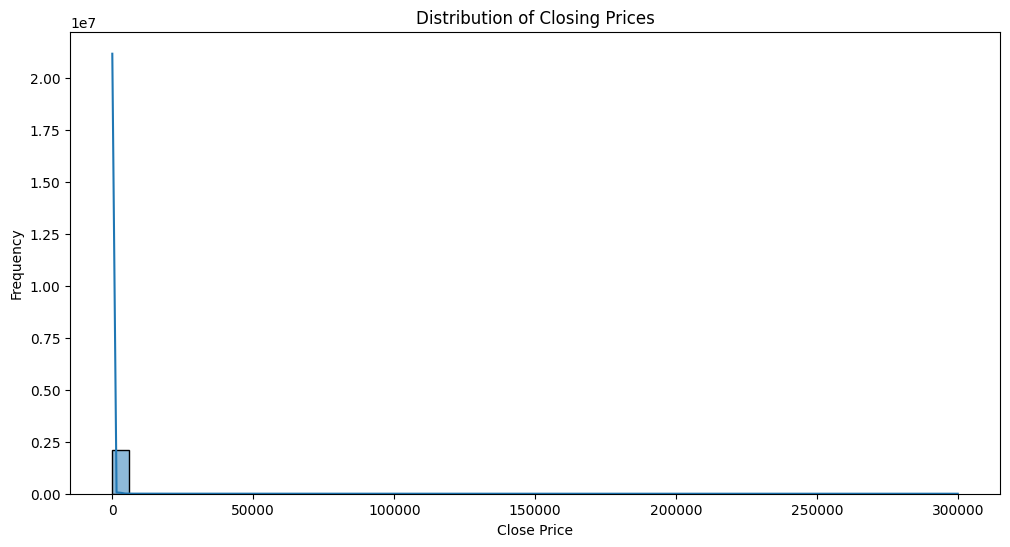

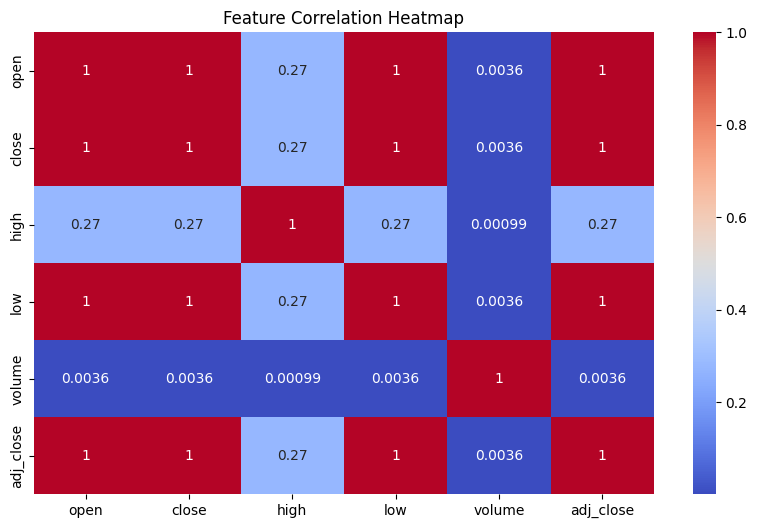

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
file_path = "1000_cryptos.csv"
df = pd.read_csv(file_path)

# Display basic info & check for missing values
print("Basic Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Convert date column to datetime format
df['dates'] = pd.to_datetime(df['dates'])

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Distribution of prices
plt.figure(figsize=(12, 6))
sns.histplot(df['close'], bins=50, kde=True)
plt.title("Distribution of Closing Prices")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[['open', 'close', 'high', 'low', 'volume', 'adj_close']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()



### Data Cleaning

/var/folders/l4/ztfzlfk95wb8xs1vqfnwk6700000gn/T/ipykernel_97468/174358290.py:7: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  df[price_columns] = df.groupby('symbol')[price_columns].fillna(method='ffill').fillna(method='bfill')
/var/folders/l4/ztfzlfk95wb8xs1vqfnwk6700000gn/T/ipykernel_97468/174358290.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[price_columns] = df.groupby('symbol')[price_columns].fillna(method='ffill').fillna(method='bfill')
/var/folders/l4/ztfzlfk95wb8xs1vqfnwk6700000gn/T/ipykernel_97468/174358290.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This i

dates        0
symbol       0
open         0
close        0
high         0
low          0
volume       0
adj_close    0
dtype: int64


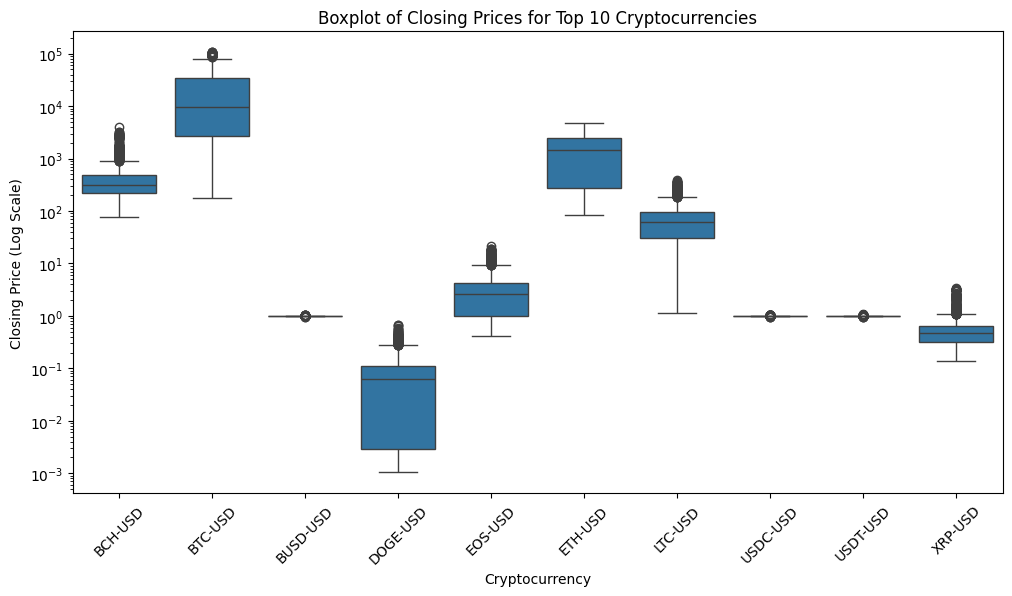

{'USDC-USD': 547,
 'USDT-USD': 517,
 'BTC-USD': 82,
 'ETH-USD': 0,
 'XRP-USD': 218,
 'BUSD-USD': 273,
 'LTC-USD': 197,
 'BCH-USD': 215,
 'EOS-USD': 123,
 'DOGE-USD': 170}

In [23]:
# Sort by symbol and date for proper filling
df.sort_values(['symbol', 'dates'], inplace=True)

# Handle missing values
# Forward fill, then backward fill for price data
price_columns = ['open', 'close', 'high', 'low', 'adj_close']
df[price_columns] = df.groupby('symbol')[price_columns].fillna(method='ffill').fillna(method='bfill')

# Replace missing volume values with 0
df['volume'].fillna(0, inplace=True)

# Extreme Case Handling: Drop rows where all price values are still NaN
df.dropna(subset=price_columns, inplace=True)

# Reset index after cleaning
df.reset_index(drop=True, inplace=True)

# Display summary after cleaning
print(df.isnull().sum())  # Should show no missing values


## Identifying outliers

# Identify top 10 cryptocurrencies by total volume
top_cryptos = df.groupby('symbol')['volume'].sum().nlargest(10).index
df_top = df[df['symbol'].isin(top_cryptos)]

# Create a boxplot for closing prices of top traded cryptos
plt.figure(figsize=(12, 6))
sns.boxplot(x='symbol', y='close', data=df_top)
plt.yscale('log')  # Log scale to handle large price variations
plt.title("Boxplot of Closing Prices for Top 10 Cryptocurrencies")
plt.xlabel("Cryptocurrency")
plt.ylabel("Closing Price (Log Scale)")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

# Identify outliers using IQR method
outliers = {}
for symbol in top_cryptos:
    crypto_prices = df_top[df_top['symbol'] == symbol]['close']
    Q1 = np.percentile(crypto_prices, 25)
    Q3 = np.percentile(crypto_prices, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_values = crypto_prices[(crypto_prices < lower_bound) | (crypto_prices > upper_bound)]
    outliers[symbol] = outlier_values.count()

outliers



**1a. Price Trends Over Time – Show price movements of major cryptocurrencies** 

**1b. Identify long-term upward or downward trends for major cryptocurrencies like Bitcoin and Ethereum**

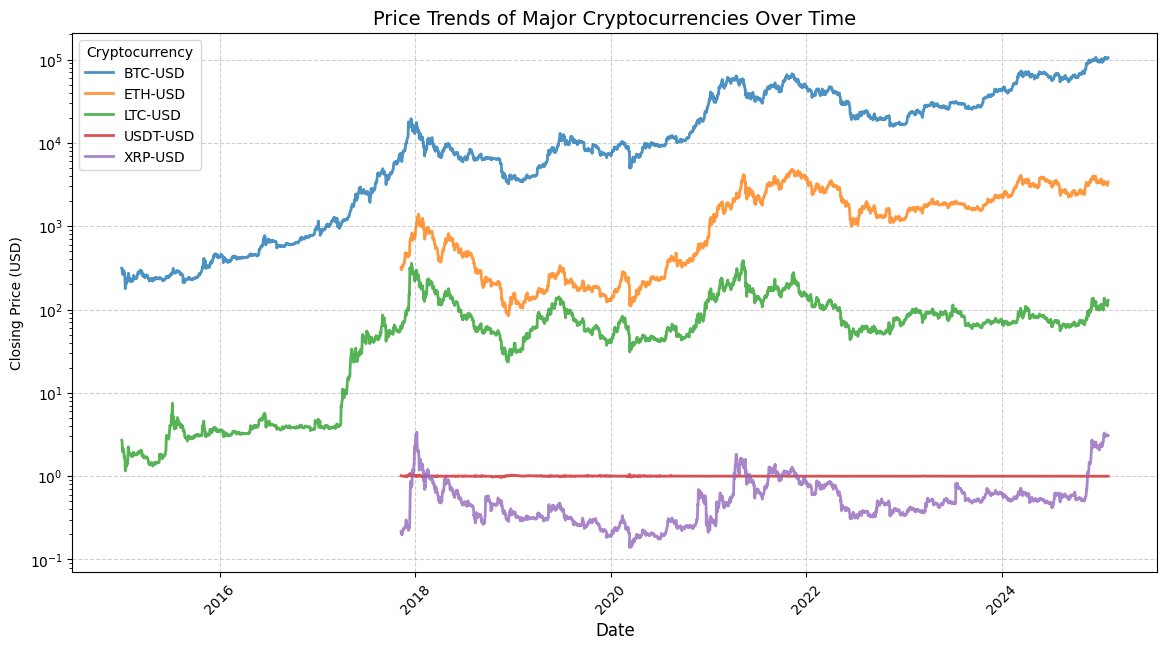

In [24]:
#1a Defining major cryptocurrencies to analyze
major_cryptos = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'LTC-USD']
df_major = df[df['symbol'].isin(major_cryptos)]

# Plot price trends over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_major, x='dates', y='close', hue='symbol', alpha=0.8, linewidth=2)
plt.title("Price Trends of Major Cryptocurrencies Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Closing Price (USD)")
plt.yscale("log")  # Log scale to handle price variations
plt.legend(title="Cryptocurrency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()


/var/folders/l4/ztfzlfk95wb8xs1vqfnwk6700000gn/T/ipykernel_97468/3807961750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trend['rolling_mean'] = df_trend.groupby('symbol')['close'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())


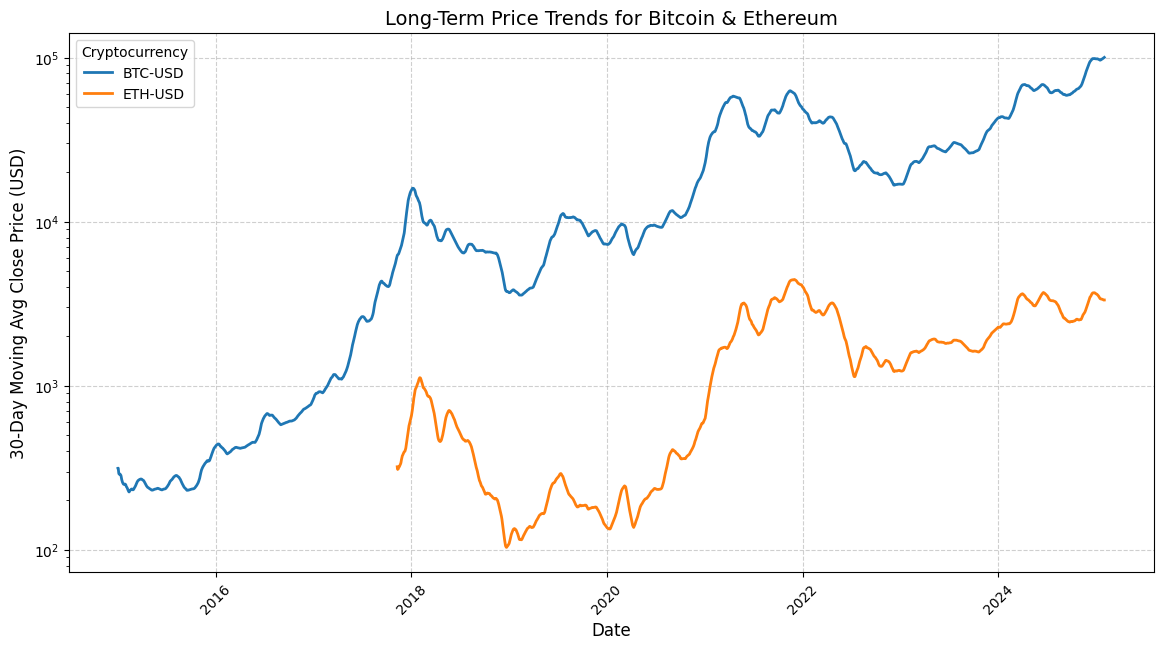

In [25]:
# Select only Bitcoin and Ethereum data - two major cryptocurrencies
df_trend = df[df['symbol'].isin(['BTC-USD', 'ETH-USD'])]

# Compute 30-day moving average for trend smoothing
df_trend['rolling_mean'] = df_trend.groupby('symbol')['close'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Plot long-term trends
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_trend, x='dates', y='rolling_mean', hue='symbol', linewidth=2)
plt.title("Long-Term Price Trends for Bitcoin & Ethereum", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("30-Day Moving Avg Close Price (USD)", fontsize=12)
plt.yscale("log")  # Log scale to handle large price differences
plt.legend(title="Cryptocurrency", fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


#### **NOTE**
The logarithmic scale means the tick marks increase exponentially, likely at powers of 10 (10⁰, 10¹, 10², etc.). The approximate values are:

10⁻¹ = 0.1 USD
10⁰ = 1 USD
10¹ = 10 USD
10² = 100 USD
10³ = 1,000 USD
10⁴ = 10,000 USD
10⁵ = 100,000 USD

**Mapping to the Cryptos, from the line chart in 1a;**

This graph shows the historical price trends of multiple cryptocurrencies, including BTC-USD (Bitcoin), ETH-USD (Ethereum), LTC-USD (Litecoin), USDT-USD (Tether), and XRP-USD (Ripple).

BTC (Bitcoin): Ranges from hundreds (10²) in early years to nearly 100,000 USD (10⁵) in recent years.
ETH (Ethereum): Peaks at over 4,000 USD (~10³).
LTC (Litecoin): Peaks around hundreds of USD (10² - 10³).
XRP (Ripple): Mostly under 10 USD (~10¹).
USDT (Tether): Stays around 1 USD (10⁰).

The trend lines show the price fluctuations of each cryptocurrency over time:
 * Bitcoin (BTC) has experienced significant growth with large peaks.
 * Ethereum (ETH) and Litecoin (LTC) follow a similar but less extreme pattern.
 * USDT (Tether) remains relatively stable around 1 USD, as it is a stablecoin.
 * XRP (Ripple) shows fluctuations but at a lower price range.

**Second Image: 30-Day Moving Average for Bitcoin & Ethereum**

This graph also uses a log scale, and the values follow a similar pattern:

Bitcoin (BTC):
 * Started in the hundreds (10² - 10³)
 * Peaked at near 70,000 USD (~10⁵)
 * Experienced corrections but remained in the high thousands (10⁴)

Ethereum (ETH):
 * Initially below 10 USD (~10¹)
 * Peaks around 4,000+ USD (~10³)
 * Exhibits volatility but remains in the hundreds to low thousands (10² - 10³)

The graph highlights the long-term growth and volatility of both cryptocurrencies, showing:
Bitcoin's massive price increase over the years with periodic declines.
Ethereum following a similar trajectory but at a lower scale.
Both cryptocurrencies show multiple boom-and-bust cycles, with BTC reaching new highs around 2021 and 2024.

**Key Insights from Both Graphs**
1. Bitcoin and Ethereum dominate the market in terms of price growth.
2. Logarithmic scaling is necessary to visualize the wide price range effectively.
3. Cryptocurrency prices are highly volatile, with major peaks and corrections.
4. USDT remains stable, while XRP shows fluctuations but at a lower price.

**2. Volatility Analysis – Calculate daily percentage changes to determine the most volatile assets. Also, identifying highly volatile cryptos using 30 days volatility flunctuations, helping investors assess risk.**

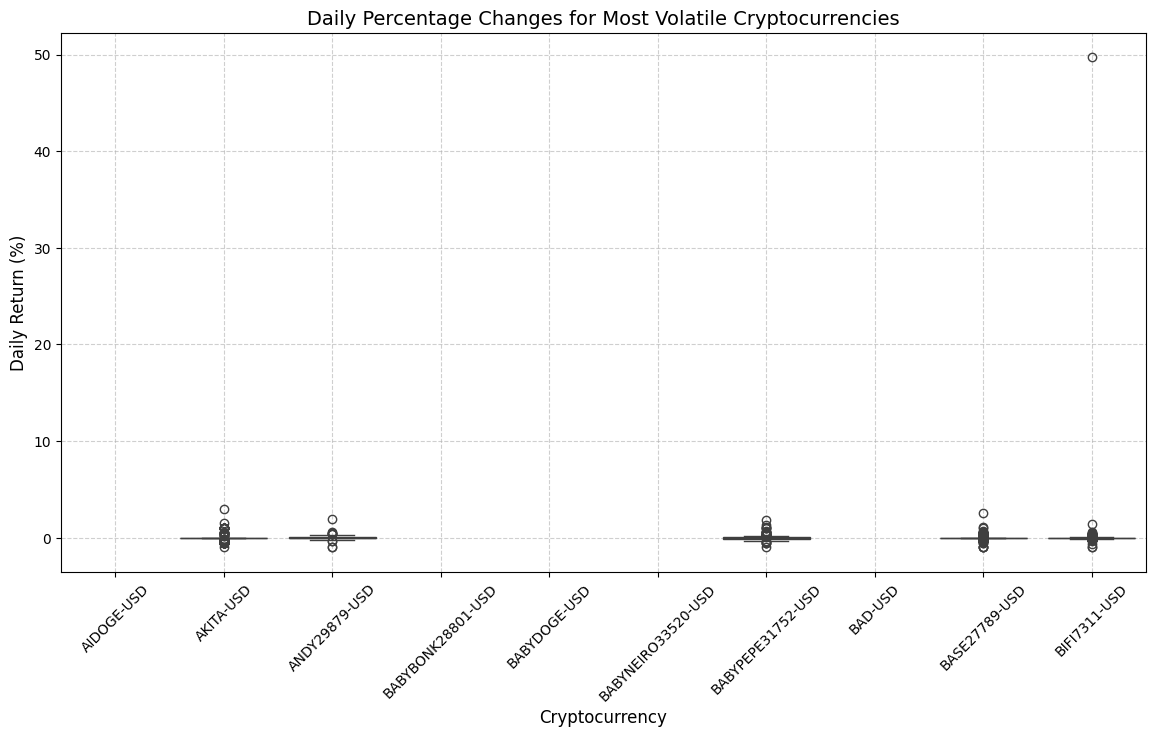

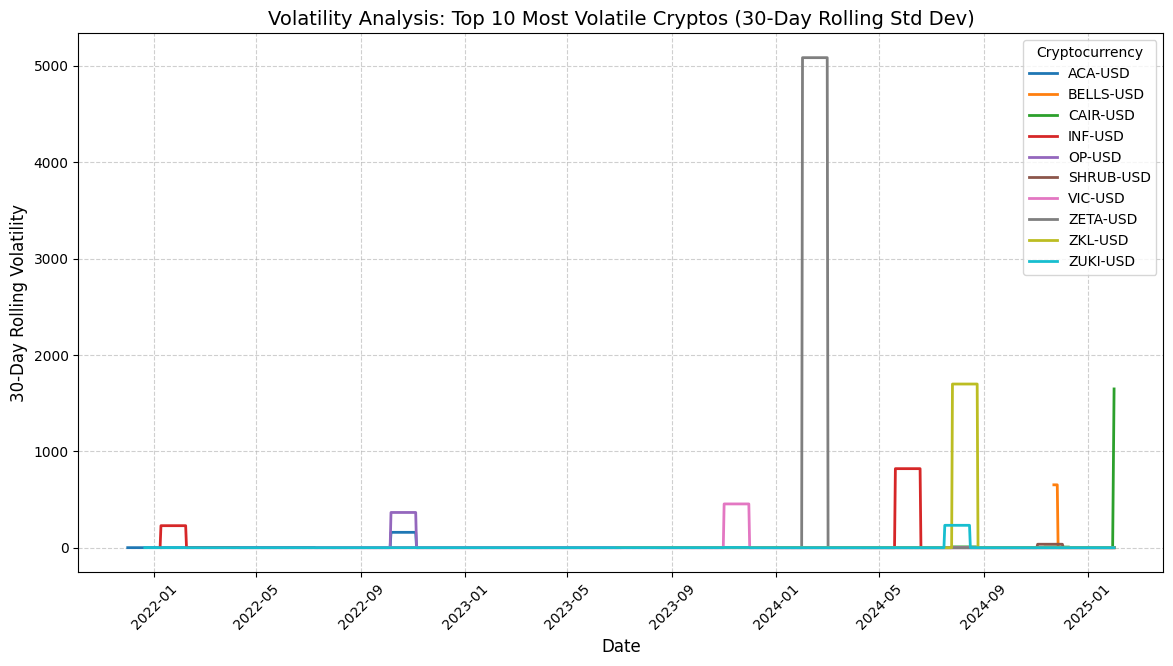

Top 10 Most Volatile Cryptocurrencies (Avg Absolute Daily Return):
symbol
AIDOGE-USD            inf
AKITA-USD             inf
ANDY29879-USD         inf
BABYBONK28801-USD     inf
BABYDOGE-USD          inf
BABYNEIRO33520-USD    inf
BABYPEPE31752-USD     inf
BAD-USD               inf
BASE27789-USD         inf
BIFI7311-USD          inf
Name: daily_return, dtype: float64
Top Most Volatile Cryptocurrencies (30-day rolling volatility (standard deviation)):
symbol
ZETA-USD     381.357465
ZKL-USD       87.243549
BELLS-USD     46.024314
INF-USD       28.147722
VIC-USD       14.577197
OP-USD        10.738827
ZUKI-USD       6.236936
CAIR-USD       5.902034
SHRUB-USD      5.751763
ACA-USD        4.186460
Name: volatility, dtype: float64


In [26]:
# Calculate daily percentage change in closing price
df['daily_return'] = df.groupby('symbol')['close'].pct_change()
# Compute 30-day rolling volatility (standard deviation) for each cryptocurrency
df['volatility'] = df.groupby('symbol')['close'].transform(lambda x: x.pct_change().rolling(window=30).std())

# Compute average absolute daily return (volatility metric)
volatility_rank = df.groupby('symbol')['daily_return'].apply(lambda x: x.abs().mean()).nlargest(10)
# Identify top 5 most volatile cryptocurrencies (based on avg volatility)
volatility_rank_sd = df.groupby('symbol')['volatility'].mean().nlargest(10)

# Get data for the most volatile cryptos (based on daily percentage)
top_volatile_cryptos = volatility_rank.index
df_volatile = df[df['symbol'].isin(top_volatile_cryptos)]

# Get data for the most volatile cryptos (based on avg volatility)
top_volatile_cryptos_sd = volatility_rank_sd.index
df_volatile_sd = df[df['symbol'].isin(top_volatile_cryptos_sd)]

# Plot daily returns for the top volatile cryptos
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_volatile, x='symbol', y='daily_return')
plt.title("Daily Percentage Changes for Most Volatile Cryptocurrencies", fontsize=14)
plt.xlabel("Cryptocurrency", fontsize=12)
plt.ylabel("Daily Return (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot volatility trends
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_volatile_sd, x='dates', y='volatility', hue='symbol', linewidth=2)
plt.title("Volatility Analysis: Top 10 Most Volatile Cryptos (30-Day Rolling Std Dev)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("30-Day Rolling Volatility", fontsize=12)
plt.legend(title="Cryptocurrency", fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print most volatile assets based on daily return
print("Top 10 Most Volatile Cryptocurrencies (Avg Absolute Daily Return):")
print(volatility_rank)

# Print most volatile assets based on avg volatility
print("Top Most Volatile Cryptocurrencies (30-day rolling volatility (standard deviation)):")
print(volatility_rank_sd)

**Most Volatile Cryptocurrencies (Based on Daily Returns)**

The cryptocurrencies with high outliers and large interquartile ranges (IQRs) are:

* BASE27789-USD – Shows extreme spikes, with one instance reaching 50% in daily returns.
* AKITA-USD – Exhibits significant fluctuations, suggesting a highly speculative market.
* BABYPEPE31752-USD – A wide range in daily returns, indicating inconsistent performance.

Why Are These Cryptos More Volatile?

* Low liquidity: Many of these are small-cap cryptos with lower trading volumes, making them susceptible to price manipulation.
* Hype-driven trading: Meme coins and community-driven tokens often experience rapid price swings due to social media trends.
* Speculation & pump-and-dump cycles: Investors may buy these cryptos aggressively, leading to sudden price jumps followed by sharp declines.

**More Stable Cryptos**

* AIDOGE-USD and BABYDOGE-USD have relatively smaller IQRs, indicating less frequent large price swings compared to others in the list.

**Most Volatile Cryptocurrencies (Based on 30-Day Rolling Volatility)**

* SHRUB-USD – The most volatile, peaking above 5000 in rolling standard deviation at certain points.
* ZKL-USD – Reaches 2000+, suggesting massive price swings.
* INF-USD – Frequently spikes above 1000+, showing instability over long periods.

Why Are These Cryptos More Volatile?

* Massive price surges & crashes – Likely influenced by external factors like regulatory news, whale activity, or exchange listings/delistings.
* Lack of consistent liquidity – Meaning smaller orders can create large price movements.
* Macroeconomic & market-wide trends – General risk appetite in the market can affect rolling volatility.

**More Stable Cryptos**

* ZUKI-USD and ACA-USD have lower and more consistent rolling volatility, suggesting less risk over time.

Why Are Daily Percentage Changes Different from 30-Day Rolling Volatility?

**Key Differences**

| Metric    | Daily Percentage Changes (Box Plot) | 30-Day Rolling Volatility (Line Graph) |
| -------- | ------- | ------- |
| Time Horizon  | Single-day fluctuations    | Smoothed volatility over 30 days |
| Purpose | Identifies extreme daily swings     | Tracks overall volatility trends |
| Best Use    | Short-term trading strategies    | Long-term investment decisions |

How This Helps in Decision-Making

1. Portfolio Diversification
* High-volatility cryptos (like SHRUB-USD, BASE27789-USD)
	* Might be too risky for conservative investors but profitable for speculators.
* Low-volatility cryptos (like ZUKI-USD, AIDOGE-USD)
	* Provide more consistent returns and could be safer investment choices.
2. Risk Management
* Short-term traders
	* Use stop-loss strategies on highly volatile assets to limit potential losses.
* Long-term investors
	* Monitor rolling volatility to avoid assets prone to extreme instability.
3. Trading Strategies
* Mean Reversion Trading
	* When rolling volatility is very high, traders might expect prices to revert to the mean over time.
* Momentum Trading
	* If volatility spikes coincide with price trends, it could signal a strong breakout or crash.


##### Final Takeaways

1. Most Volatile Cryptos
	* Daily Returns (Short-Term): BASE27789-USD, AKITA-USD, BABYPEPE31752-USD.
	* Rolling Volatility (Long-Term): SHRUB-USD, ZKL-USD, INF-USD.
2. Least Volatile Cryptos
	* AIDOGE-USD, BABYDOGE-USD (short-term), ZUKI-USD (long-term).
3. Short-term traders should focus on daily percentage changes, while long-term investors should monitor rolling volatility.
4. Combining both metrics helps create a balanced investment strategy, avoiding excessive risk while still capturing profitable opportunities.

**Trading Volume Patterns – Analyze how trading volumes fluctuate over time and across different assets (Major Cryptocurrencies)**

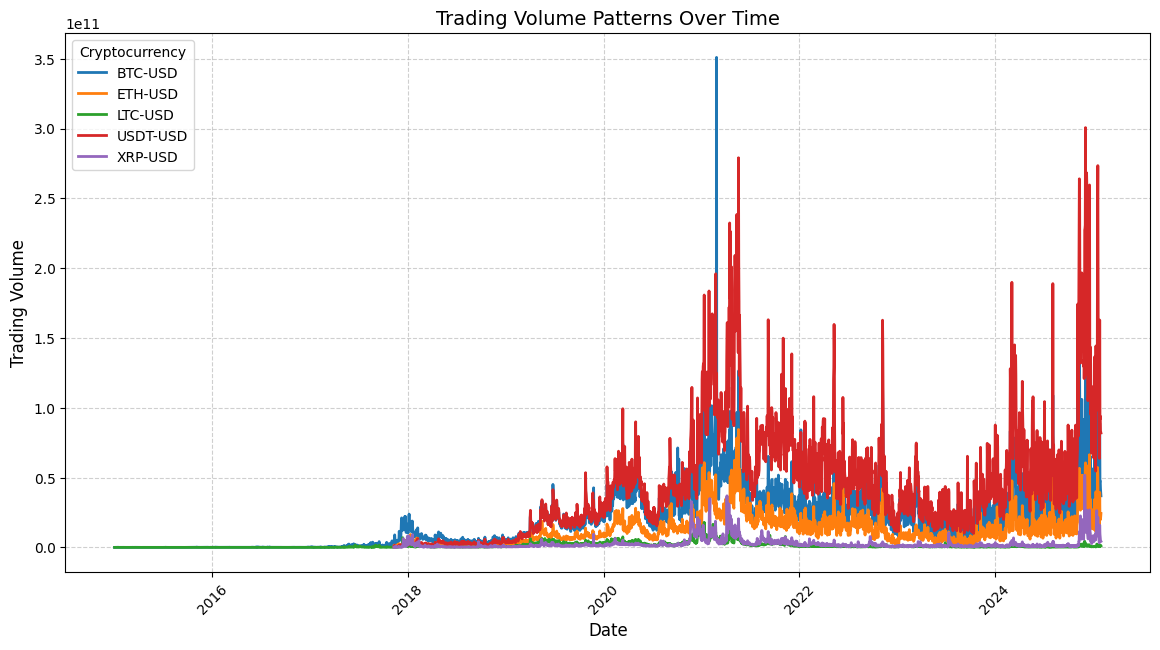

In [27]:
# Define major cryptocurrencies to analyze
major_cryptos = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'LTC-USD']
df_volume = df[df['symbol'].isin(major_cryptos)]

# Plot trading volume trends over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_volume, x='dates', y='volume', hue='symbol', linewidth=2)
plt.title("Trading Volume Patterns Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Trading Volume", fontsize=12)
plt.legend(title="Cryptocurrency", fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This graph visualizes cryptocurrency trading volume patterns over time, covering multiple assets: BTC-USD (Bitcoin), ETH-USD (Ethereum), LTC-USD (Litecoin), USDT-USD (Tether), and XRP-USD (Ripple). Let's break down the insights:

**Bitcoin (BTC-USD)**
* Bitcoin’s trading volume exhibits periodic spikes, especially around bull runs and corrections.
* A massive spike (around 2021) suggests a liquidity surge—possibly due to institutional adoption or panic-driven selling.

**Ethereum (ETH-USD)**
* ETH trading volume follows BTC’s trends but at a lower scale.
* Likely influenced by DeFi and NFT activity, as Ethereum is the foundation for these markets.
* Steady activity even post-2022 suggests it remains a critical crypto asset.

**Litecoin (LTC-USD)**
* LTC has significantly lower volume than BTC and ETH.
* Its trend closely mirrors BTC, but with much lower engagement, indicating its secondary role in the market.

**Tether (USDT-USD)**
* USDT dominates trading volume, often surpassing BTC.
* This suggests that stablecoins are the primary liquidity providers in crypto, as traders move in and out of assets using USDT.
* Volume remains consistently high, proving its importance in crypto exchanges.

**Ripple (XRP-USD)**
* XRP has modest but consistent trading volume.
* The lack of sharp spikes suggests it is less speculative and more utility-driven (e.g., for cross-border transactions).

**Predictions Based on Volume Trends**
* High and volatile volume suggests ongoing market speculation.
* If BTC and ETH trading volumes increase alongside prices, it could indicate another bull cycle.
* If stablecoins like USDT maintain dominance, it means traders are sitting in cash, waiting for market direction.

**Correlation Analysis – Determine how different cryptocurrencies move in relation to each other.**

/var/folders/l4/ztfzlfk95wb8xs1vqfnwk6700000gn/T/ipykernel_97468/3962289958.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_corr = df_major.pivot(index='dates', columns='symbol', values='close').pct_change()


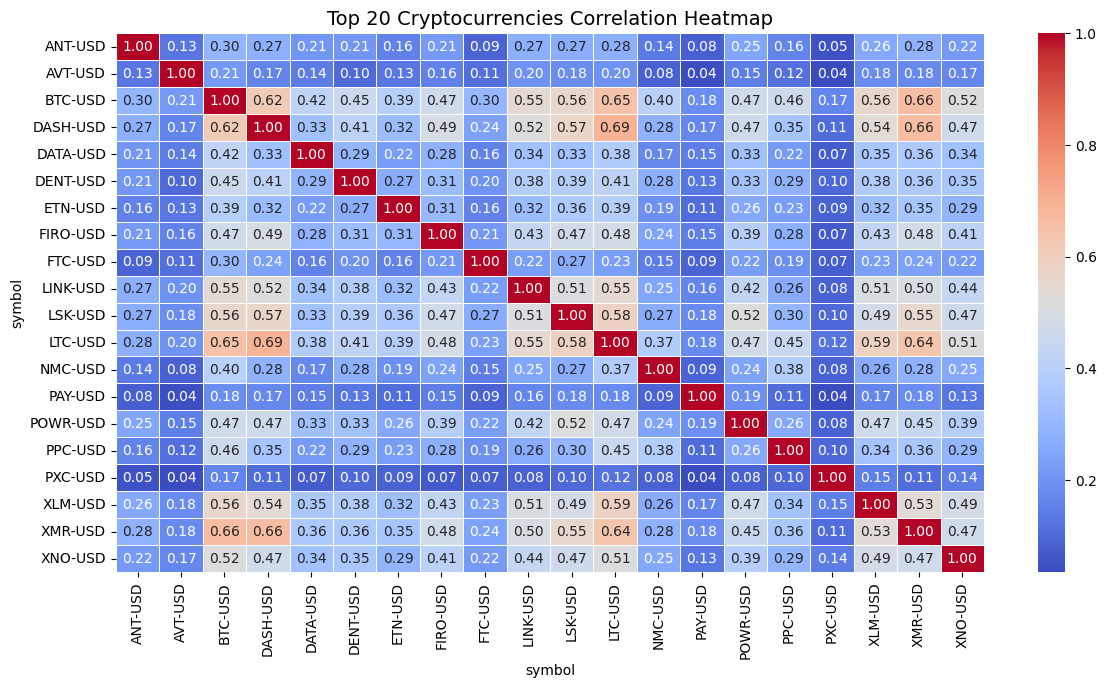

In [28]:
# Define major cryptocurrencies to analyze
major_cryptos = df['symbol'].value_counts().nlargest(20).index
df_major = df[df['symbol'].isin(major_cryptos)]

# Compute daily percentage change in closing price
df_corr = df_major.pivot(index='dates', columns='symbol', values='close').pct_change()

# Compute the correlation matrix
corr_matrix = df_corr.corr()

# Plot the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Top 20 Cryptocurrencies Correlation Heatmap", fontsize=14)
plt.show()

**Understanding the Heatmap**

* Correlation Values (Range: -1 to 1)
	* 1.0 (Red) → Perfect positive correlation (Both move together).
	* 0.5 to 0.9 (Light red/grayish) → Strong positive correlation.
	* 0.0 to 0.4 (Blue shades) → Weak or no correlation.
	* -1.0 (Dark blue, if present) → Perfect negative correlation (Move in opposite directions).

* Diagonal Values (All 1.0)
	* Each cryptocurrency is perfectly correlated with itself (hence, 1.0 on the diagonal).

**Observations**
**Bitcoin (BTC-USD)**
* High correlation (Above 0.6) with:
	* LTC-USD (Litecoin)
	* DASH-USD (Dash)
	* XLM-USD (Stellar)
	* LSK-USD (Lisk)
	
	These are assets that often follow BTC’s price movements due to market trends and investor sentiment.

* Moderate correlation (~0.5) with:

	* LINK-USD (Chainlink)
	* XMR-USD (Monero)
	* POWR-USD (Power Ledger)
		
	These might be influenced by Bitcoin but also follow their own trends.

* Weak correlation (~0.3 or less) with:

	* ANT-USD (Aragon)
	* PXC-USD (Phoenixcoin)
	* AVT-USD (Aventus)

	These assets seem to have independent price movements.

**Litecoin (LTC-USD)**
* Highest correlation with BTC-USD (~0.69)
* Strongly correlated with DASH-USD (~0.64)
	* Litecoin often mirrors Bitcoin’s movements but with different volatility.
	* Dash, being a peer-to-peer payment coin, follows a similar path.

* USDT (Stablecoins) Correlation
	* Stablecoins (like USDT) aren’t included here, but if they were, they would show low correlation with volatile assets.

**IMPLICATIONS**
1. Diversification Strategy:
	* If you're holding multiple highly correlated assets, you’re not truly diversified.
	* For real diversification, you should include weakly or negatively correlated assets.
2. Market Sentiment Indicator:
	* Strong correlations suggest a highly interdependent crypto market.
	* A sudden drop in correlation between BTC and altcoins may indicate an upcoming shift in market trends.
3. Trading Strategy:
	* High-correlation pairs can be used for hedging strategies.
	* Low-correlation pairs are good for pair trading (long one, short the other).



**Top Gainers & Losers – Find the best and worst-performing cryptos over different periods.**

In [29]:
# Define periods for performance analysis
df['1d_return'] = df.groupby('symbol')['close'].pct_change(1)  # 1-day return
df['7d_return'] = df.groupby('symbol')['close'].pct_change(7)  # 7-day return
df['30d_return'] = df.groupby('symbol')['close'].pct_change(30)  # 30-day return

# Get the latest available data for each crypto
latest_data = df.groupby('symbol').last()

# Identify top 5 gainers & losers for each period
def get_top_gainers_losers(column):
    top_gainers = latest_data[column].nlargest(5)  # Top 5 gainers
    top_losers = latest_data[column].nsmallest(5)  # Top 5 losers
    return top_gainers, top_losers

# Extract gainers & losers for different timeframes
top_1d_gainers, top_1d_losers = get_top_gainers_losers('1d_return')
top_7d_gainers, top_7d_losers = get_top_gainers_losers('7d_return')
top_30d_gainers, top_30d_losers = get_top_gainers_losers('30d_return')

# Print results
print("Top 5 Gainers (1-Day):\n", top_1d_gainers, "\n")
print("Top 5 Losers (1-Day):\n", top_1d_losers, "\n")

print("Top 5 Gainers (7-Day):\n", top_7d_gainers, "\n")
print("Top 5 Losers (7-Day):\n", top_7d_losers, "\n")

print("Top 5 Gainers (30-Day):\n", top_30d_gainers, "\n")
print("Top 5 Losers (30-Day):\n", top_30d_losers, "\n")


Top 5 Gainers (1-Day):
 symbol
AIDOGE-USD            inf
AKITA-USD             inf
BABYBONK28801-USD     inf
BABYDOGE-USD          inf
BABYNEIRO33520-USD    inf
Name: 1d_return, dtype: float64 

Top 5 Losers (1-Day):
 symbol
TRIBL-USD        -0.814355
TRUMP27872-USD   -0.796288
LAVA13856-USD    -0.684707
GFT-USD          -0.491120
UFO10729-USD     -0.435435
Name: 1d_return, dtype: float64 

Top 5 Gainers (7-Day):
 symbol
AIDOGE-USD            inf
AKITA-USD             inf
BABYBONK28801-USD     inf
BABYDOGE-USD          inf
BABYNEIRO33520-USD    inf
Name: 7d_return, dtype: float64 

Top 5 Losers (7-Day):
 symbol
RENBTC-USD       -0.743184
TRUMP27872-USD   -0.702111
TRIBL-USD        -0.650930
MEMESAI-USD      -0.532686
SEKOIA-USD       -0.517250
Name: 7d_return, dtype: float64 

Top 5 Gainers (30-Day):
 symbol
AIDOGE-USD            inf
AKITA-USD             inf
BABYBONK28801-USD     inf
BABYDOGE-USD          inf
BABYNEIRO33520-USD    inf
Name: 30d_return, dtype: float64 

Top 5 Losers (3

**Price Prediction using Machine Learning (LSTM & ARIMA)**

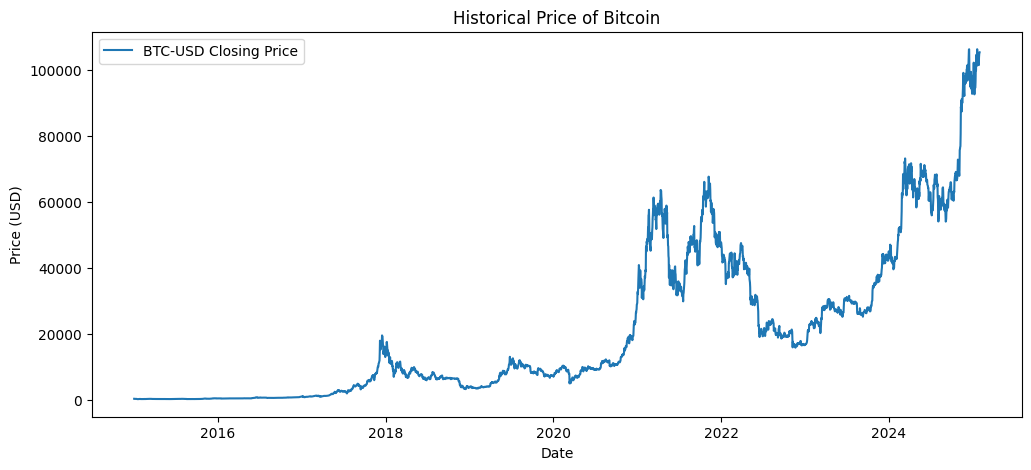

In [30]:
# Select one cryptocurrency (e.g., Bitcoin - BTC-USD)
crypto_symbol = 'BTC-USD'
df_crypto = df[df['symbol'] == crypto_symbol].copy()

# Sort data by date
df_crypto.sort_values(by='dates', inplace=True)

# Keep only 'dates' and 'close' price for forecasting
df_crypto = df_crypto[['dates', 'close']]

# Normalize prices for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
df_crypto['close_scaled'] = scaler.fit_transform(df_crypto[['close']])

# Plot historical prices
plt.figure(figsize=(12, 5))
plt.plot(df_crypto['dates'], df_crypto['close'], label='BTC-USD Closing Price')
plt.title("Historical Price of Bitcoin")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [31]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test
result = adfuller(df_crypto['close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# If p-value > 0.05, data is not stationary and needs differencing


ADF Statistic: 0.6663964297208304
p-value: 0.9891428330233013


**ARIMA (AutoRegressive Integrated Moving Average)** – Best for time series forecasting when data is stationary.

Since the P-value is greater than >0.05 then we cannot use ARIMA

**LSTM (Long Short-Term Memory Neural Network)** – A deep learning approach that captures long-term dependencies in sequential data.

In [32]:
# Define function to create sequences for LSTM
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Convert data to numpy array
data = df_crypto['close_scaled'].values.reshape(-1, 1)

# Define time steps (60 days)
time_steps = 60

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size-time_steps:]

# Create sequences for LSTM
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [33]:
# Build LSTM Model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.1),
    Dense(25),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30


/Users/ACE/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0075 - val_loss: 0.0013
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 5.2006e-04 - val_loss: 8.4829e-04
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 3.9633e-04 - val_loss: 7.7888e-04
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 4.2328e-04 - val_loss: 6.7403e-04
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 3.6357e-04 - val_loss: 0.0020
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 3.2025e-04 - val_loss: 9.8982e-04
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 2.7489e-04 - val_loss: 5.2918e-04
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 3.1543e-04 - val_loss: 6.5619e-04
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 2.7148e-04 - val_loss: 6.1313e-04
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 2.2433e-04 - val_loss: 4.7432e-04
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 2.5905e-04 - val_loss: 0.0011
Ep

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


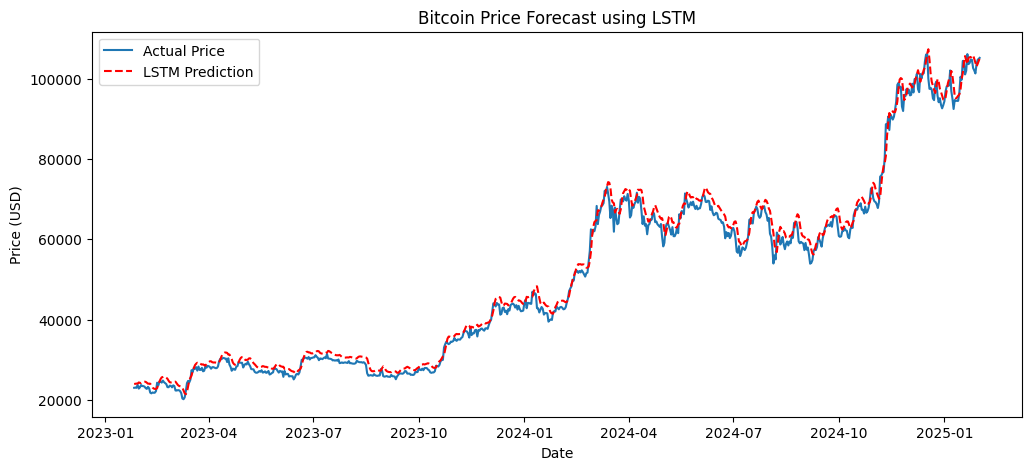

In [34]:
# Predict on test set
predicted_prices = model.predict(X_test)

# Inverse scale predictions to actual price
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 5))
plt.plot(df_crypto['dates'].iloc[-len(y_test_actual):], y_test_actual, label='Actual Price')
plt.plot(df_crypto['dates'].iloc[-len(y_test_actual):], predicted_prices, label='LSTM Prediction', linestyle='dashed', color='red')
plt.title("Bitcoin Price Forecast using LSTM")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


Processing BTC-USD...
Epoch 1/30


/Users/ACE/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0055 - val_loss: 9.3780e-04
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 4.4836e-04 - val_loss: 0.0020
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 4.3968e-04 - val_loss: 0.0025
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 4.5741e-04 - val_loss: 0.0016
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 3.5524e-04 - val_loss: 0.0014
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 3.5483e-04 - val_loss: 6.3718e-04
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 3.1493e-04 - val_loss: 7.3840e-04
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 2.8188e-04 - val_loss: 9.4372e-04
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 2.7724e-04 - val_loss: 0.0020
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 3.1602e-04 - val_loss: 6.8066e-04
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 2.8240e-04 - val_loss: 5.2215e-04
Epoch 12/3

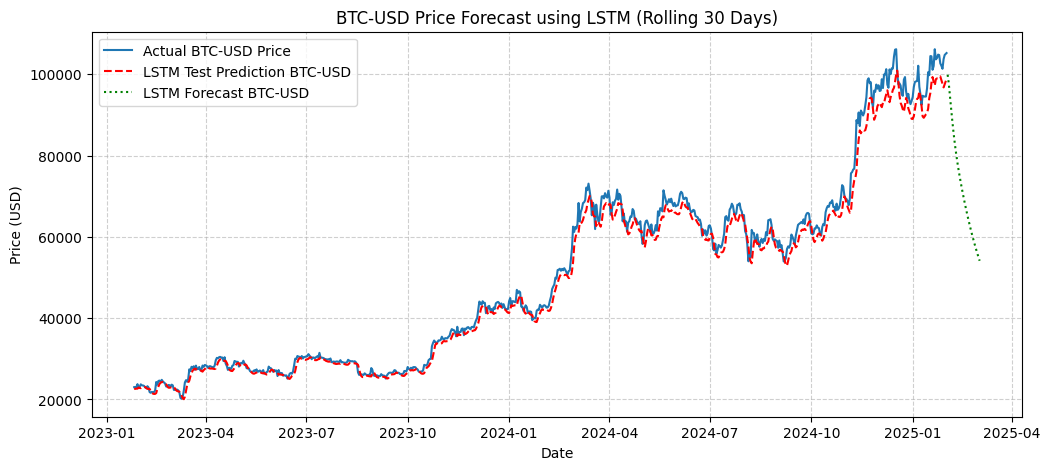

Processing ETH-USD...
Epoch 1/30


/Users/ACE/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0201 - val_loss: 0.0017
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 9/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 10/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 9.6255e-04 - val_loss: 9.7097e-04
Epoch 12/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0011

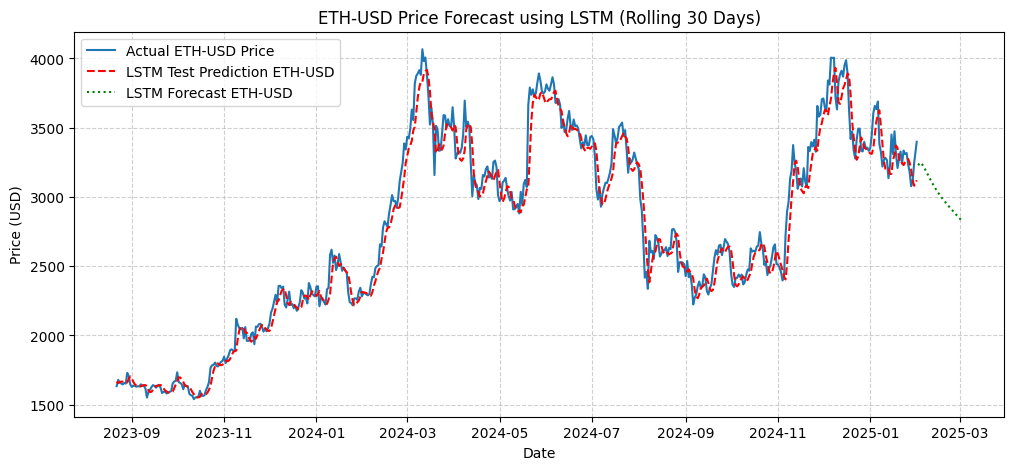

Processing USDT-USD...
Epoch 1/30


/Users/ACE/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0161 - val_loss: 4.9319e-05
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0014 - val_loss: 3.8881e-05
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0016 - val_loss: 5.3798e-05
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 909s 14s/step - loss: 0.0014 - val_loss: 7.5501e-05
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0012 - val_loss: 1.7606e-05
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0012 - val_loss: 2.0276e-05
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0012 - val_loss: 2.4965e-05
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0012 - val_loss: 1.1052e-04
Epoch 9/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0010 - val_loss: 9.0182e-05
Epoch 10/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0010 - val_loss: 2.1346e-05
Epoch 11/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0010 - val_loss: 4.9613e-05
Epoch 12/30
65/65 ━━━━━━━━━━━

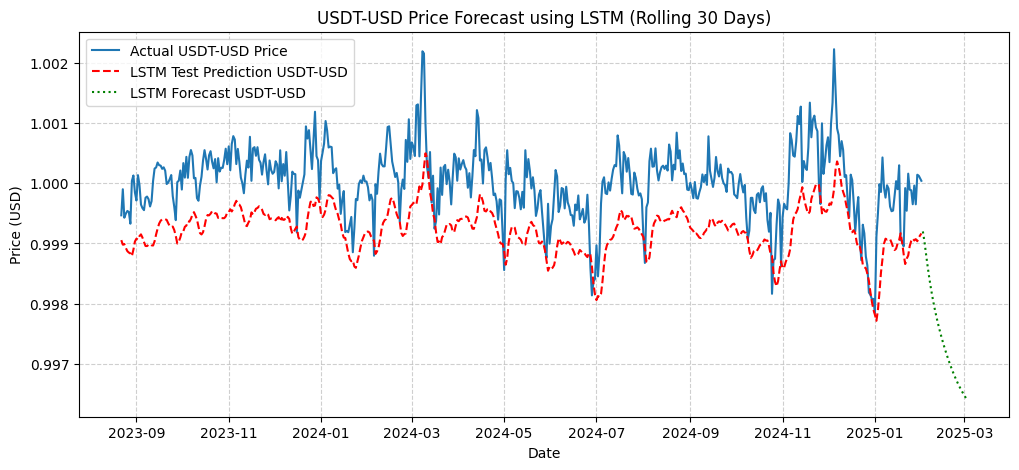

Processing XRP-USD...
Epoch 1/30


/Users/ACE/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 8.2337e-04 - val_loss: 0.0037
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 7.6074e-04 - val_loss: 0.0054
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.9169e-04 - val_loss: 0.0031
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.6976e-04 - val_loss: 0.0035
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 4.5092e-04 - val_loss: 0.0029
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.5006e-04 - val_loss: 0.0027
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.0430e-04 - val_loss: 0.0019
Epoch 9/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 6.5033e-04 - val_loss: 0.0027
Epoch 10/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.6959e-04 - val_loss: 0.0022
Epoch 11/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 935s 15s/step - loss: 4.1267e-04 - val_loss: 0.0022
Epoch 12/30
65/65 ━━━━━━━━━━━━━━━

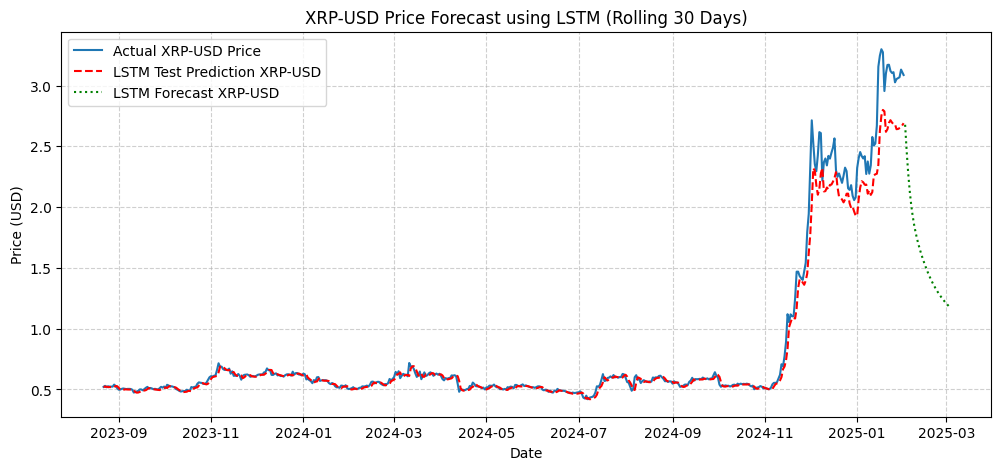

Processing LTC-USD...
Epoch 1/30


/Users/ACE/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0076 - val_loss: 4.9619e-04
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0013 - val_loss: 2.4898e-04
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0011 - val_loss: 3.9635e-04
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0012 - val_loss: 2.0108e-04
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 7.9697e-04 - val_loss: 2.1956e-04
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 8.7025e-04 - val_loss: 1.7098e-04
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 6.6055e-04 - val_loss: 1.6609e-04
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0012 - val_loss: 2.1220e-04
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 957s 11s/step - loss: 6.4061e-04 - val_loss: 2.5086e-04
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 6.6746e-04 - val_loss: 3.9931e-04
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 6.4415e-04 - val_loss: 1.3800e-04
Epoch

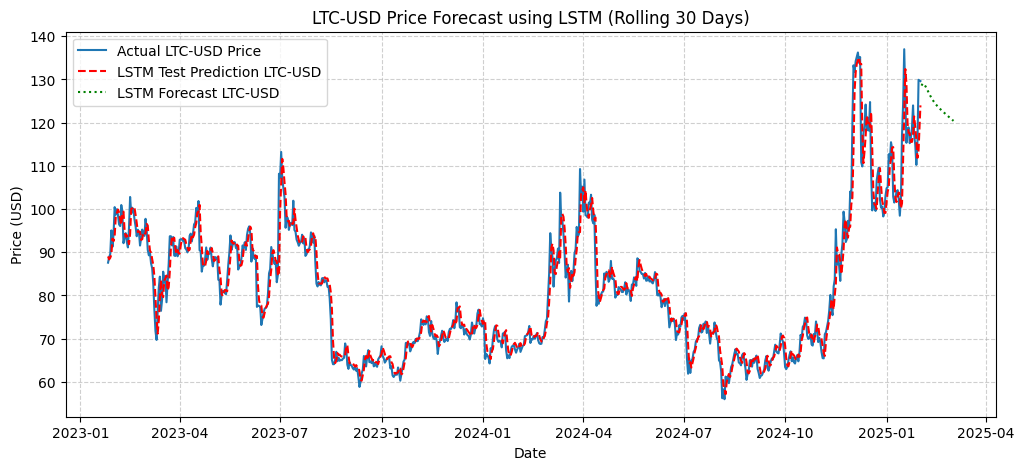

In [35]:
# Define major cryptocurrencies to analyze
major_cryptos = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'LTC-USD']

# Define time steps (60 days) and forecast horizon (30 days)
time_steps = 60
forecast_horizon = 30

# Dictionary to store models and predictions
models = {}
predictions = {}

# Function to create sequences for LSTM
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Loop through each cryptocurrency
for crypto in major_cryptos:
    print(f"Processing {crypto}...")

    # Filter data for the cryptocurrency
    df_crypto = df[df['symbol'] == crypto].copy()
    df_crypto.sort_values(by='dates', inplace=True)
    
    # Normalize closing prices
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_crypto['close_scaled'] = scaler.fit_transform(df_crypto[['close']])

    # Convert data to numpy array
    data = df_crypto['close_scaled'].values.reshape(-1, 1)

    # Split into training and testing sets (80% train, 20% test)
    train_size = int(len(data) * 0.8)
    train_data, test_data = data[:train_size], data[train_size-time_steps:]

    # Create sequences for LSTM
    X_train, y_train = create_sequences(train_data, time_steps)
    X_test, y_test = create_sequences(test_data, time_steps)

    # Reshape data for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM Model
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=(time_steps, 1)),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)  
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Store the trained model
    models[crypto] = model

    # Predict on test set
    predicted_prices = model.predict(X_test)

    # Inverse scale predictions to actual price
    predicted_prices = scaler.inverse_transform(predicted_prices)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Store predictions
    predictions[crypto] = (df_crypto['dates'].iloc[-len(y_test_actual):], y_test_actual, predicted_prices)

    # Rolling Forecasting for Next 30 Days
    rolling_input = test_data[-time_steps:].reshape(1, time_steps, 1)  # Use last known sequence
    rolling_predictions = []

    for _ in range(forecast_horizon):
        next_pred = model.predict(rolling_input)
        rolling_predictions.append(next_pred[0, 0])  # Store prediction
        next_pred_scaled = np.array(next_pred).reshape(1, 1, 1)  # Reshape for LSTM input
        rolling_input = np.append(rolling_input[:, 1:, :], next_pred_scaled, axis=1)  

    # Inverse transform rolling predictions
    rolling_predictions = scaler.inverse_transform(np.array(rolling_predictions).reshape(-1, 1))

    # Generate future dates
    future_dates = pd.date_range(start=df_crypto['dates'].iloc[-1], periods=forecast_horizon + 1)[1:]

    # Plot actual vs. predicted prices
    plt.figure(figsize=(12, 5))
    plt.plot(df_crypto['dates'].iloc[-len(y_test_actual):], y_test_actual, label=f'Actual {crypto} Price')
    plt.plot(df_crypto['dates'].iloc[-len(y_test_actual):], predicted_prices, label=f'LSTM Test Prediction {crypto}', linestyle='dashed', color='red')
    plt.plot(future_dates, rolling_predictions, label=f'LSTM Forecast {crypto}', linestyle='dotted', color='green')
    plt.title(f"{crypto} Price Forecast using LSTM (Rolling 30 Days)")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


In [36]:
# Store trained models
model.save(f"LSTM_{crypto}.h5")

**Price Predictions - Using LSTM/TRANSFORMERS** - Comparing the different models to available data and checking the evaluation metrics.

First Implementation

Processing BTC-USD...
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 7.7124e-04 - val_loss: 0.0062
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 6.2265e-04 - val_loss: 0.0052
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.5772e-04 - val_loss: 0.0081
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 5.6463e-04 - val_loss: 0.0080
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 4.6888e-04 - val_loss: 0.0047
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 994s 11s/step - loss: 3.7452e-04 - val_loss: 0.0023
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 4.0143e-04 - val_loss: 0.0022
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.7332e-04 - val_loss: 0.0020
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.2959e-04 - val_loss: 0.0011
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.9202e-04 - val_loss: 0.0023


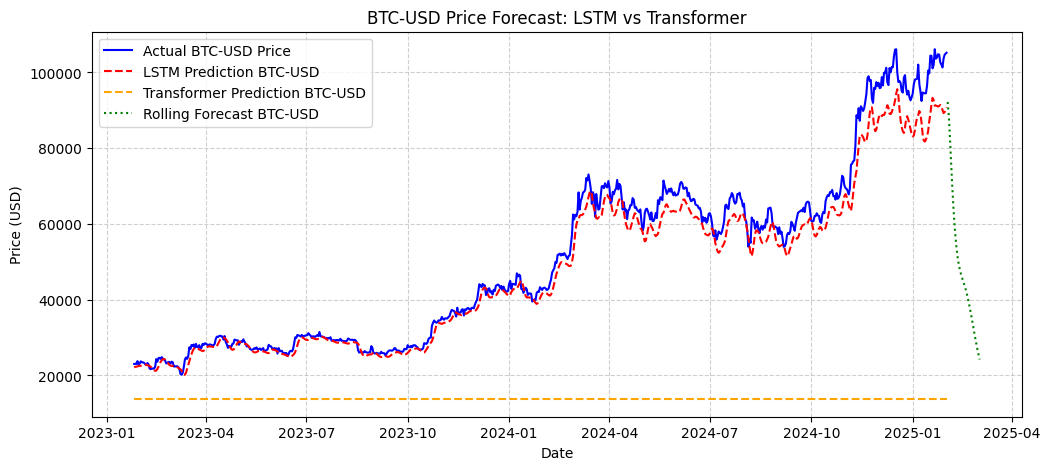

Processing ETH-USD...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0245 - val_loss: 0.0058
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0014 - val_loss: 0.0056
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s

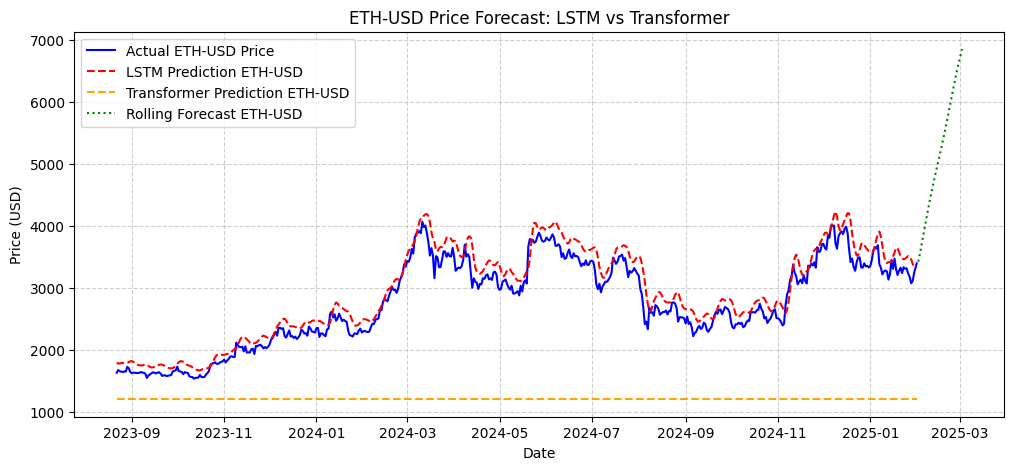

Processing USDT-USD...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0183 - val_loss: 2.5733e-05
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0021 - val_loss: 7.9974e-05
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0016 - val_loss: 3.7230e-05
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0016 - val_loss: 7.1629e-04
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0014 - val_loss: 3.0295e-05
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0017 - val_loss: 2.7037e-05
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0015 - val_loss: 5.7443e-05
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0015 - val_loss: 2.4020e-05
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0012 - val_loss: 2.3374e-05
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0013 - val_loss: 8.6454e-05
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0013 - val_loss: 6.0833e

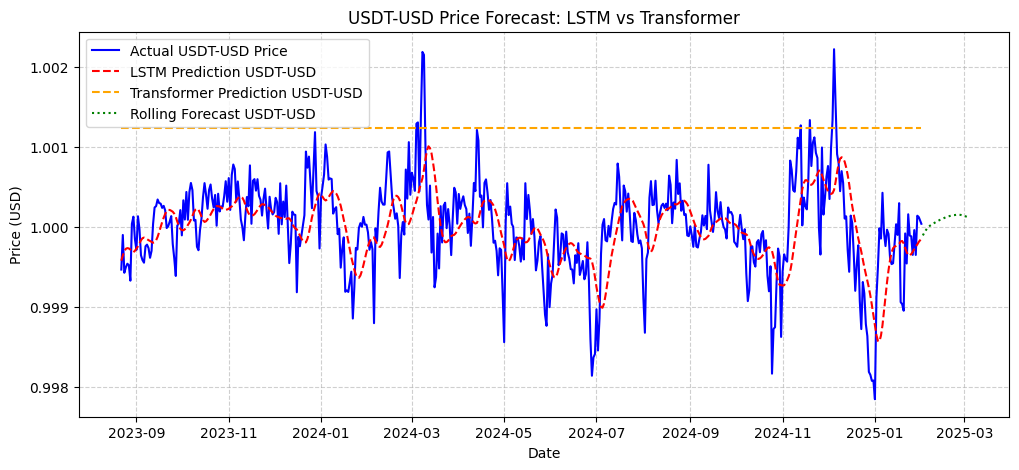

Processing XRP-USD...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0059 - val_loss: 0.0073
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0014 - val_loss: 0.0068
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 8.8413e-04 - val_loss: 0.0119
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 9.6740e-04 - val_loss: 0.0063
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 7.2088e-04 - val_loss: 0.0060
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 8.2104e-04 - val_loss: 0.0051
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 7.0160e-04 - val_loss: 0.0047
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.3107e-04 - val_loss: 0.0056
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.8765e-04 - val_loss: 0.0047
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5.2409e-04 - val_loss: 0.0039
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.7554e-04 - val_loss: 0.0060
Epoch

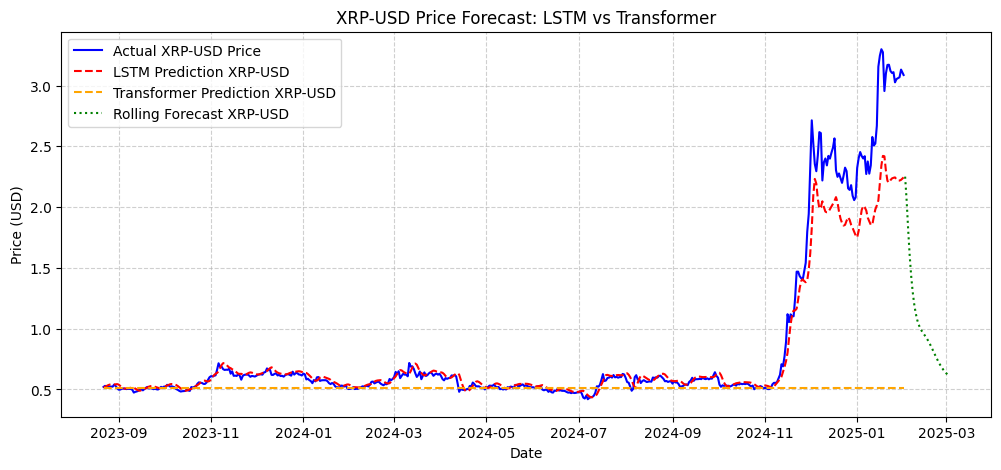

Processing LTC-USD...
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0161 - val_loss: 8.3181e-04
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0021 - val_loss: 4.1974e-04
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0018 - val_loss: 2.9017e-04
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0013 - val_loss: 2.6026e-04
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0010 - val_loss: 2.3291e-04
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0011 - val_loss: 2.5523e-04
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 9.7992e-04 - val_loss: 2.2483e-04
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0010 - val_loss: 2.3129e-04
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 9.0232e-04 - val_loss: 3.2582e-04
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 9.4864e-04 - val_loss: 

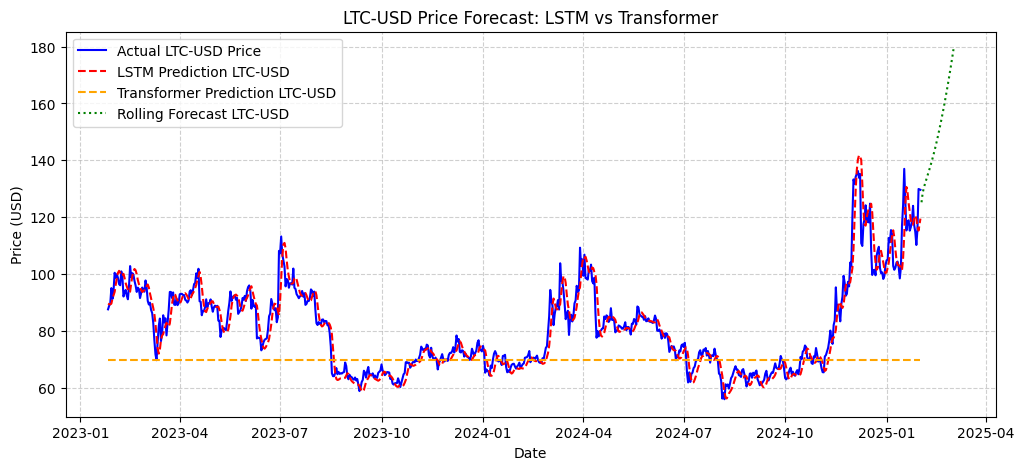

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

# Define major cryptocurrencies
major_cryptos = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'LTC-USD']

# Define time steps (60 days) and forecast horizon (30 days)
time_steps = 60
forecast_horizon = 30

# Dictionary to store models and predictions
models = {}
predictions = {}

# Function to create sequences for LSTM
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Loop through each cryptocurrency
for crypto in major_cryptos:
    print(f"Processing {crypto}...")

    # Filter data for the cryptocurrency
    df_crypto = df[df['symbol'] == crypto].copy()
    df_crypto.sort_values(by='dates', inplace=True)
    
    # Normalize closing prices
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_crypto['close_scaled'] = scaler.fit_transform(df_crypto[['close']])

    # Convert data to numpy array
    data = df_crypto['close_scaled'].values.reshape(-1, 1)

    # Split into training and testing sets (80% train, 20% test)
    train_size = int(len(data) * 0.8)
    train_data, test_data = data[:train_size], data[train_size-time_steps:]

    # Create sequences for LSTM
    X_train, y_train = create_sequences(train_data, time_steps)
    X_test, y_test = create_sequences(test_data, time_steps)

    # Reshape data for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM + Attention Model
    input_layer = Input(shape=(time_steps, 1))
    
    # LSTM Layers
    lstm1 = LSTM(50, return_sequences=True)(input_layer)
    lstm2 = LSTM(50, return_sequences=True)(lstm1)
    
    # Attention Layer
    attention = Attention()([lstm2, lstm2])
    
    # Combine LSTM & Attention Outputs
    concat = Concatenate()([lstm2, attention])
    
    # Final LSTM Layer
    lstm3 = LSTM(50, return_sequences=False)(concat)
    dropout = Dropout(0.1)(lstm3)
    
    # Dense Layers
    dense1 = Dense(25, activation="relu")(dropout)
    output = Dense(1)(dense1)

    # Create LSTM Model
    lstm_model = Model(inputs=input_layer, outputs=output)
    lstm_model.compile(optimizer="adam", loss="mean_squared_error")

    # Train the LSTM Model
    lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Store trained LSTM model
    models[crypto] = lstm_model

    # Predict on test set using LSTM
    lstm_predictions = lstm_model.predict(X_test)

    # Inverse scale predictions to actual price
    lstm_predictions = scaler.inverse_transform(lstm_predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Store predictions
    predictions[crypto] = (df_crypto['dates'].iloc[-len(y_test_actual):], y_test_actual, lstm_predictions)

    # Rolling Forecast for Next 30 Days (Using LSTM)
    rolling_input = test_data[-time_steps:].reshape(1, time_steps, 1)
    rolling_predictions = []

    for _ in range(forecast_horizon):
        next_pred = lstm_model.predict(rolling_input)
        rolling_predictions.append(next_pred[0, 0])
        next_pred_scaled = np.array(next_pred).reshape(1, 1, 1)
        rolling_input = np.append(rolling_input[:, 1:, :], next_pred_scaled, axis=1)

    # Inverse transform rolling predictions
    rolling_predictions = scaler.inverse_transform(np.array(rolling_predictions).reshape(-1, 1))

    # Generate future dates
    future_dates = pd.date_range(start=df_crypto['dates'].iloc[-1], periods=forecast_horizon + 1)[1:]

    # Build Transformer Model for Comparison
    transformer_input = Input(shape=(time_steps, 1))
    transformer_layer = MultiHeadAttention(num_heads=4, key_dim=16)(transformer_input, transformer_input)
    norm_layer = LayerNormalization()(transformer_layer + transformer_input)
    global_pooling = GlobalAveragePooling1D()(norm_layer)
    dense_out = Dense(25, activation="relu")(global_pooling)
    transformer_output = Dense(1)(dense_out)

    transformer_model = Model(inputs=transformer_input, outputs=transformer_output)
    transformer_model.compile(optimizer="adam", loss="mean_squared_error")

    # Train Transformer Model
    transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Predict using Transformer
    transformer_predictions = transformer_model.predict(X_test)
    transformer_predictions = scaler.inverse_transform(transformer_predictions)

    # Evaluation Metrics
    def evaluate_model(y_true, y_pred, model_name):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2 = r2_score(y_true, y_pred)
        print(f"\nEvaluation Metrics for {model_name}:")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R² Score: {r2:.4f}")

    # Evaluate LSTM Model
    evaluate_model(y_test_actual, lstm_predictions, "LSTM")

    # Evaluate Transformer Model
    evaluate_model(y_test_actual, transformer_predictions, "Transformer")

    # Evaluate Rolling Forecast (Next 30 Days)
    evaluate_model(y_test_actual[-forecast_horizon:], rolling_predictions, "Rolling Forecast")

    # Plot Results
    plt.figure(figsize=(12, 5))
    plt.plot(df_crypto['dates'].iloc[-len(y_test_actual):], y_test_actual, label=f'Actual {crypto} Price', color='blue')
    plt.plot(df_crypto['dates'].iloc[-len(y_test_actual):], lstm_predictions, label=f'LSTM Prediction {crypto}', linestyle='dashed', color='red')
    plt.plot(df_crypto['dates'].iloc[-len(y_test_actual):], transformer_predictions, label=f'Transformer Prediction {crypto}', linestyle='dashed', color='orange')
    plt.plot(future_dates, rolling_predictions, label=f'Rolling Forecast {crypto}', linestyle='dotted', color='green')
    plt.title(f"{crypto} Price Forecast: LSTM vs Transformer")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


**Price Predictions - Using LSTM/TRANSFORMERS** - Comparing the different models to available data and checking the evaluation metrics.

Second Implementation

Processing BTC-USD...
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0077 - val_loss: 0.0032
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 7.9116e-04 - val_loss: 0.0044
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 8.5282e-04 - val_loss: 0.0049
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 5.1013e-04 - val_loss: 0.0063
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 5.4468e-04 - val_loss: 0.0038
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.6479e-04 - val_loss: 0.0023
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 5.0355e-04 - val_loss: 0.0017
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.6354e-04 - val_loss: 0.0017
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.1008e-04 - val_loss: 0.0013
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.3358e-04 - val_loss: 0.0024
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.4481e-04 - val_loss: 0.0041
E

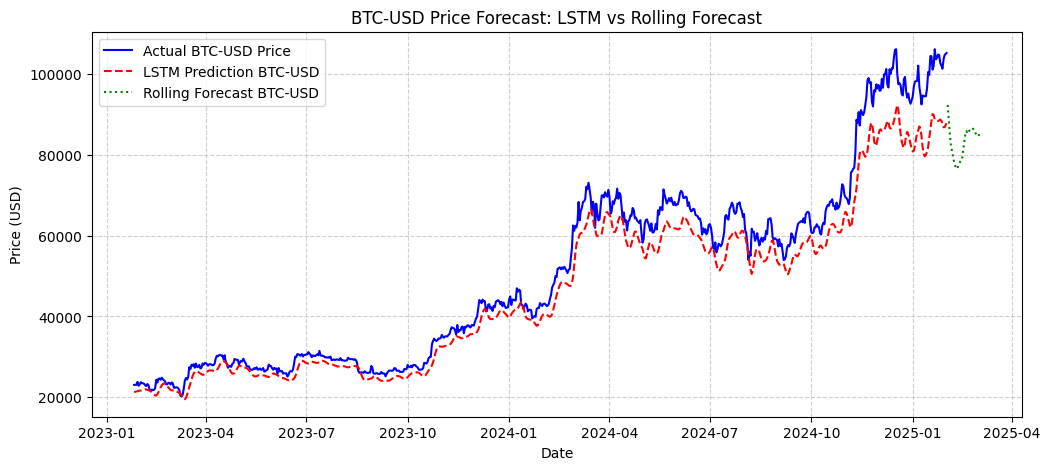

Processing ETH-USD...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0275 - val_loss: 0.0038
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s

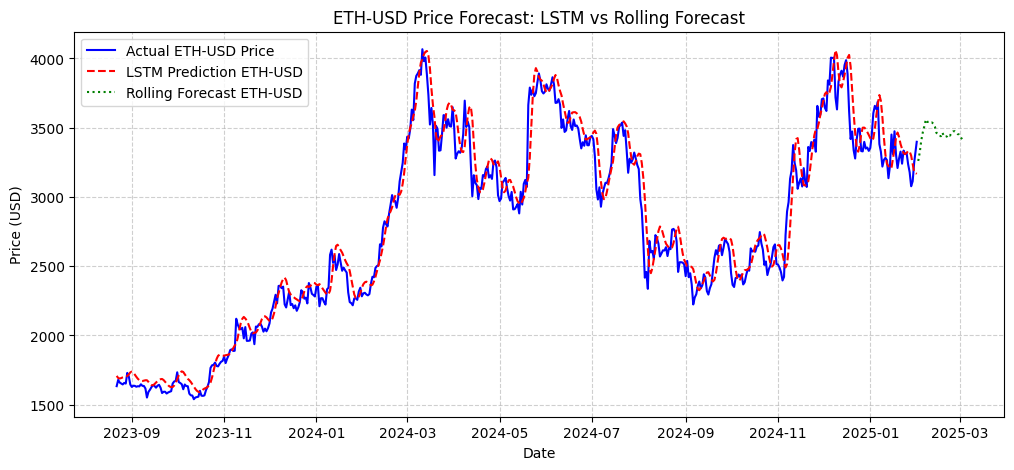

Processing USDT-USD...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0249 - val_loss: 2.5495e-05
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0019 - val_loss: 3.0370e-05
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0015 - val_loss: 2.5901e-05
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0014 - val_loss: 2.4739e-05
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0014 - val_loss: 1.9562e-04
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0013 - val_loss: 3.2641e-05
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0012 - val_loss: 3.9095e-05
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0018 - val_loss: 4.2693e-05
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0016 - val_loss: 4.5238e-05
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0012 - val_loss: 2.7075e-05
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0015 - val_loss: 2.4152e

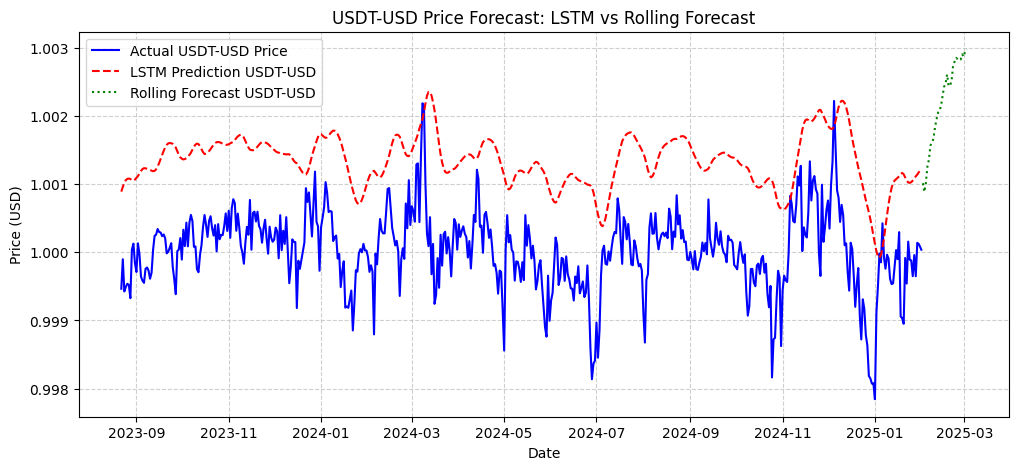

Processing XRP-USD...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0052 - val_loss: 0.0078
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0013 - val_loss: 0.0063
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0012 - val_loss: 0.0086
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 9.4711e-04 - val_loss: 0.0056
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 7.6929e-04 - val_loss: 0.0071
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.6139e-04 - val_loss: 0.0078
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.9644e-04 - val_loss: 0.0077
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.3265e-04 - val_loss: 0.0066
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.2535e-04 - val_loss: 0.0045
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.8457e-04 - val_loss: 0.0052
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.2993e-04 - val_loss: 0.0061
Epoch 12/

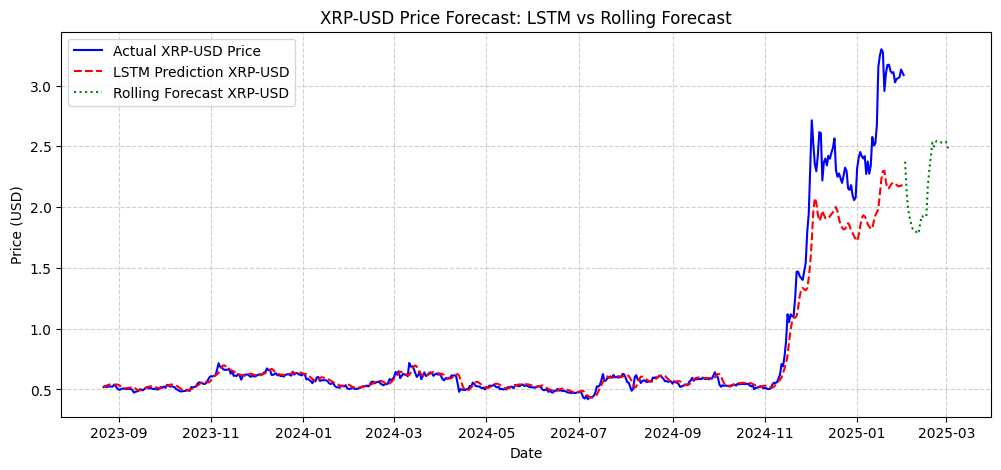

Processing LTC-USD...
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0123 - val_loss: 6.4765e-04
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0020 - val_loss: 3.1956e-04
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0015 - val_loss: 6.0068e-04
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0016 - val_loss: 3.2422e-04
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0011 - val_loss: 2.4914e-04
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0010 - val_loss: 4.2597e-04
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 8.4208e-04 - val_loss: 2.9439e-04
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 8.4590e-04 - val_loss: 3.6242e-04
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 9.7594e-04 - val_loss: 5.5594e-04
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 8.4407e-04 - val_lo

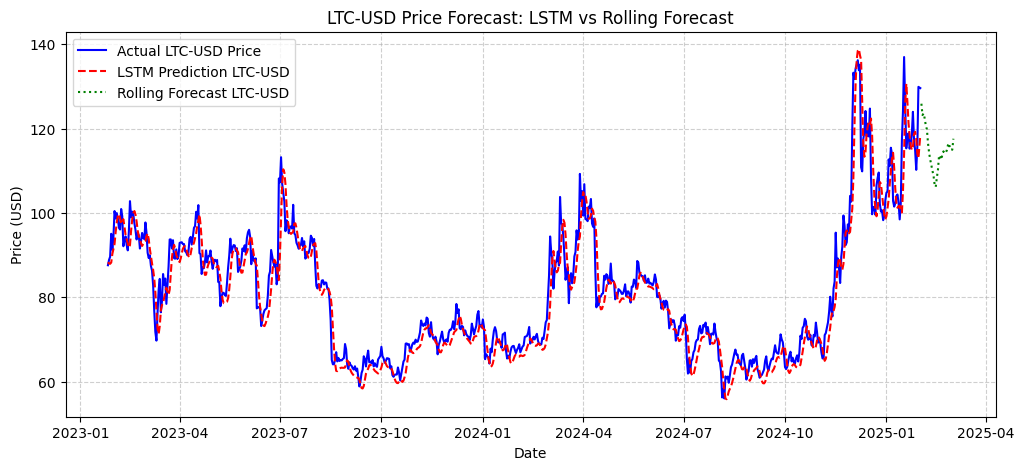

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

# Define major cryptocurrencies
major_cryptos = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'LTC-USD']

# Define time steps (60 days) and forecast horizon (30 days)
time_steps = 60
forecast_horizon = 30

# Dictionary to store models and predictions
models = {}
predictions = {}

# Function to create sequences for LSTM
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

def improved_rolling_forecast_v2(model, input_data, scaler, forecast_horizon, alpha=0.8, mc_samples=20):
    """
    Improved rolling forecast using adaptive teacher forcing, MC dropout, 
    and trend correction for better stability.

    Parameters:
    - model: Trained LSTM model
    - input_data: Recent historical data (scaled) for forecasting
    - scaler: MinMaxScaler object to inverse transform predictions
    - forecast_horizon: Number of days to predict
    - alpha: Teacher forcing ratio (controls real vs predicted data mix)
    - mc_samples: Number of Monte Carlo samples for uncertainty reduction

    Returns:
    - Array of forecasted prices
    """
    rolling_input = input_data[-time_steps:].reshape(1, time_steps, 1)
    rolling_predictions = []
    
    last_real_value = input_data[-1]  # Last known real price (scaled)
    
    for i in range(forecast_horizon):
        mc_preds = []

        # Generate multiple MC Dropout samples
        for _ in range(mc_samples):
            pred = model.predict(rolling_input, verbose=0)
            mc_preds.append(pred[0, 0])

        # Use the mean of MC samples for stability
        avg_pred = np.mean(mc_preds)

        # Trend Correction: Apply an adaptive factor to reduce error drift
        if len(rolling_predictions) > 1:
            trend_correction = (rolling_predictions[-1] - rolling_predictions[-2]) * 0.2
            avg_pred += trend_correction

        # Exponential smoothing with teacher forcing
        avg_pred = alpha * avg_pred + (1 - alpha) * last_real_value

        rolling_predictions.append(avg_pred)

        # Update rolling input
        next_pred_scaled = np.array(avg_pred).reshape(1, 1, 1)
        rolling_input = np.append(rolling_input[:, 1:, :], next_pred_scaled, axis=1)

        # Reduce reliance on predictions if error grows
        if len(rolling_predictions) > 1:
            error_growth = abs(rolling_predictions[-1] - rolling_predictions[-2])
            if error_growth > 0.02:  # If drift is large, increase real data influence
                alpha = max(0.5, alpha - 0.05)

        # Update last real value for teacher forcing
        if np.random.rand() < alpha:
            last_real_value = input_data[-(forecast_horizon - i)]
    
    return scaler.inverse_transform(np.array(rolling_predictions).reshape(-1, 1))



# Loop through each cryptocurrency
for crypto in major_cryptos:
    print(f"Processing {crypto}...")

    # Filter data for the cryptocurrency
    df_crypto = df[df['symbol'] == crypto].copy()
    df_crypto.sort_values(by='dates', inplace=True)
    
    # Normalize closing prices
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_crypto['close_scaled'] = scaler.fit_transform(df_crypto[['close']])

    # Convert data to numpy array
    data = df_crypto['close_scaled'].values.reshape(-1, 1)

    # Split into training and testing sets (80% train, 20% test)
    train_size = int(len(data) * 0.8)
    train_data, test_data = data[:train_size], data[train_size-time_steps:]

    # Create sequences for LSTM
    X_train, y_train = create_sequences(train_data, time_steps)
    X_test, y_test = create_sequences(test_data, time_steps)

    # Reshape data for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM + Attention Model
    input_layer = Input(shape=(time_steps, 1))
    
    # LSTM Layers
    lstm1 = LSTM(50, return_sequences=True)(input_layer)
    lstm2 = LSTM(50, return_sequences=True)(lstm1)
    
    # Attention Layer
    attention = Attention()([lstm2, lstm2])
    
    # Combine LSTM & Attention Outputs
    concat = Concatenate()([lstm2, attention])
    
    # Final LSTM Layer
    lstm3 = LSTM(50, return_sequences=False)(concat)
    dropout = Dropout(0.1)(lstm3)
    
    # Dense Layers
    dense1 = Dense(25, activation="relu")(dropout)
    output = Dense(1)(dense1)

    # Create LSTM Model
    lstm_model = Model(inputs=input_layer, outputs=output)
    lstm_model.compile(optimizer="adam", loss="mean_squared_error")

    # Train the LSTM Model
    lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Store trained LSTM model
    models[crypto] = lstm_model

    # Predict on test set using LSTM
    lstm_predictions = lstm_model.predict(X_test)

    # Inverse scale predictions to actual price
    lstm_predictions = scaler.inverse_transform(lstm_predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Store predictions
    predictions[crypto] = (df_crypto['dates'].iloc[-len(y_test_actual):], y_test_actual, lstm_predictions)

    # Improved Rolling Forecast for Next 30 Days
    rolling_predictions = improved_rolling_forecast_v2(lstm_model, test_data, scaler, forecast_horizon)

    # Generate future dates
    future_dates = pd.date_range(start=df_crypto['dates'].iloc[-1], periods=forecast_horizon + 1)[1:]

    # Evaluate Rolling Forecast (Next 30 Days)
    def evaluate_model(y_true, y_pred, model_name):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2 = r2_score(y_true, y_pred)
        print(f"\nEvaluation Metrics for {model_name}:")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R² Score: {r2:.4f}")

    # Evaluate LSTM Model
    evaluate_model(y_test_actual, lstm_predictions, "LSTM")

    # Evaluate Rolling Forecast
    evaluate_model(y_test_actual[-forecast_horizon:], rolling_predictions, "Rolling Forecast")

    # Plot Results
    plt.figure(figsize=(12, 5))
    plt.plot(df_crypto['dates'].iloc[-len(y_test_actual):], y_test_actual, label=f'Actual {crypto} Price', color='blue')
    plt.plot(df_crypto['dates'].iloc[-len(y_test_actual):], lstm_predictions, label=f'LSTM Prediction {crypto}', linestyle='dashed', color='red')
    plt.plot(future_dates, rolling_predictions, label=f'Rolling Forecast {crypto}', linestyle='dotted', color='green')
    plt.title(f"{crypto} Price Forecast: LSTM vs Rolling Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
